# Introduction

In this notebook we will once again visualise daily sentiment data, however we will take a look at sentiment representations that seem more likely to be informative than the naive approach in the previous notebook of starting from an already aggregated average daily sentiment. We will start from the individual sentiments per tweet, do some preprocessing on this data and then try to aggregate it in a few different ways which we suspect will do a better job at validating our research question than the previous attempt.

# Loading in the data
The individual tweet sentiment data can be fount in /data/tweets_sentiment.csv. We will load this data in and drop all unnecessary columns.


In [156]:
import pandas as pd 
import numpy as np 
import os
from os import path
import matplotlib.pyplot as plt

Again we first set the /data directory as our work space.

In [158]:
#check if data directory is in its expected place
if not path.isdir(os.getcwd()+'/data'):
    #if not in this directory try parent directory
    original = path.dirname(os.getcwd())
    os.chdir(original)
    parent = os.getcwd()
    if not path.isdir(parent+'/data'):
        raise Exception("No data directory was found at %s or %s"%(original, parent))
    else:
        os.chdir(os.getcwd()+'/data')

else:
    os.chdir(os.getcwd()+'/data')

Now we can load the csv file into a Pandas dataframe.

In [160]:
df = pd.read_csv("tweets_sentiment.csv", index_col=0)
df.head(5)

,id,date,text_en,sentiment
0,1237879827773804545,20200311,"Roel, survive vn covid-19, up to max. 9days. ...",0.8312
1,1237875536807882754,20200311,"My colleague Kurt Barbe:\r\n""One does n' t hav...",0.5719
2,1237869570192334851,20200311,"100 times a day, I hear say, ""Hand wash hands ...",0.4939
3,1237864826128478208,20200311,"Meanwhile, player of the virus has taken care ...",0.6808
4,1237863661445627907,20200311,I heard a source that this coming from Mao-Ch...,-0.2500


Since we already have the sentiment value of each tweet, we are not actually interested in the tweet text itself so we can drop this column. We will also drop the id column and the unnamed column since we are only interested in grouping the tweets by day anyway.

In [162]:
df.columns

Index(['id', 'date', 'text_en', 'sentiment'], dtype='object')

In [164]:
df = df.drop(["id", "text_en"], axis = 1)

We will now once again transform the date column to support the Pandas datetime format

In [166]:
df["date"] = df["date"].apply(lambda x:str(x))
df["date"] = df["date"].apply(lambda x:x[4:6]+"/"+x[6::]+"/"+x[:4:])
df["date"] = pd.to_datetime(df["date"])

In [168]:
df.head(5)

,date,sentiment
0,2020-03-11,0.8312
1,2020-03-11,0.5719
2,2020-03-11,0.4939
3,2020-03-11,0.6808
4,2020-03-11,-0.2500


Now we have everything necessary to aggregate the data and visualise the results. Let's get going!

# Visualising
## Fraction of negative tweets of total number of 'sentimental' tweets
A first measure we expect to indicate something about the peak of the epidemic would be the negative tweets as a fraction of the total number of sentimental or non-neutral tweets for each day. To achieve this we will first need to filter out all neutral tweets from the data set.

The sentiment analysis tool used to extract the sentiment values was Vader Sentiment. This is an analysis tool which will assign a sentiment value to a string in the range [-1, 1] which can be discretized in the following way: values in the range \[-1, -0.1\] are considered negative, values in the range \[-0.1, 0.1\] neutral and values in the range \[0.1, 1\] are considered positive. More information about the Vader Sentiment tool can be found here:

https://github.com/cjhutto/vaderSentiment

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. 
Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

To filter out the neutral tweets we can just aply a boolean filter to the sentiment column:

In [170]:
df_sentimental = df[abs(df["sentiment"])>0.1]
print("length before filtering: %d"%len(df))
print("length after filtering: %d"%len(df_sentimental))
print("fraction of neutral tweets: %f"%(len(df)/len(df_sentimental) - 1))

length before filtering: 8361
length after filtering: 6131
fraction of neutral tweets: 0.363725


As you can see there were quite a few neutral tweets. These tweets might have been the root cause of the noise that was discussed in the previous notebook. Now that only the 'sentimental' tweets remain we can start on our visualisation. First we will create a new column 'is_positive' which will contain a binary value indicating if the sentiment was positive. Using this column we can then calculate the fraction of negative tweets (i.e. tweets where the column 'is_positive' is 0). 

In [172]:
df_sentimental['is_positive'] = np.where(df_sentimental['sentiment']>0, 1, 0)
df_sentimental['is_negative'] = np.where(df_sentimental['sentiment']<0, 1, 0)
df_sentimental['checksum'] = df_sentimental['is_positive']+df_sentimental['is_negative']
df_sentimental.head(5)

,date,sentiment,is_positive,is_negative,checksum
0,2020-03-11,0.8312,1,0,1
1,2020-03-11,0.5719,1,0,1
2,2020-03-11,0.4939,1,0,1
3,2020-03-11,0.6808,1,0,1
4,2020-03-11,-0.2500,0,1,1


In [174]:
df_sentimental_negative_fraction = df_sentimental.groupby('date').agg({'is_negative': 'mean'})
df_sentimental_negative_fraction.head()

,is_negative
date,
2020-03-11,0.446809
2020-03-12,0.466960
2020-03-13,0.400000
2020-03-14,0.372222
2020-03-15,0.383085


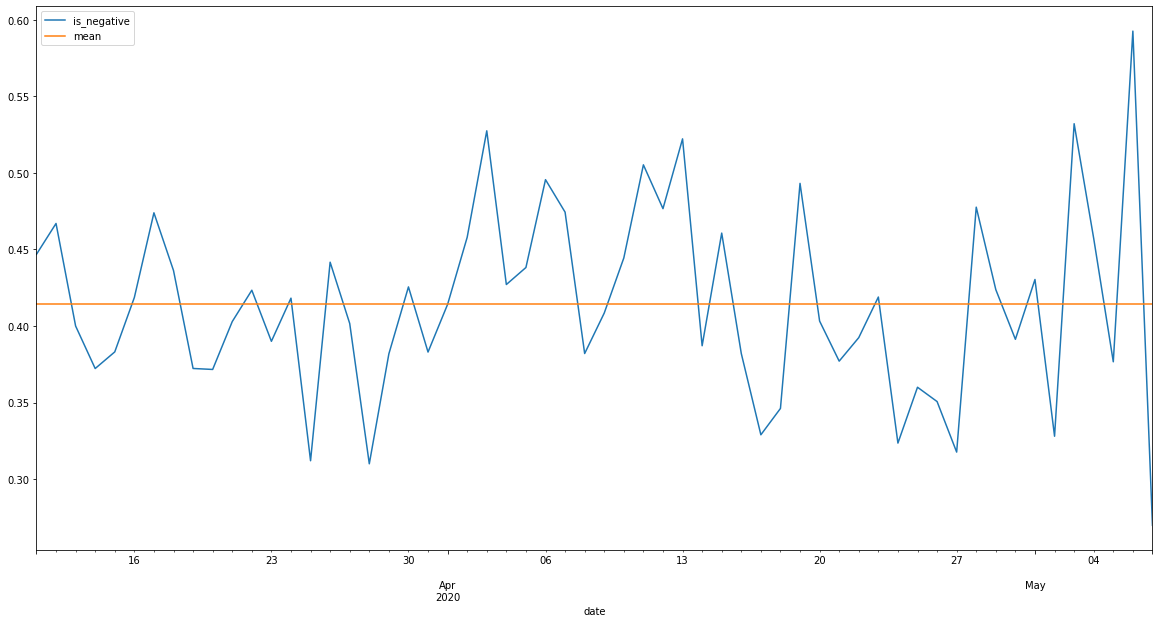

In [175]:
df_sentimental_negative_fraction['mean'] = df_sentimental_negative_fraction['is_negative'].mean()
df_sentimental_negative_fraction.plot.line(figsize=(20, 10))

As you can see the spike in negative tweets in the middle of the graph above the mean fraction of negative tweets across the entire time period is clearly visible here. However the graph is not really smooth. Perhaps we would be able to achieve a more smooth graph if we applied a rolling window averaging out the noise across multiple days. Instead of taking the daily average we will now take the moving average across a 7 day window. Let's try this:

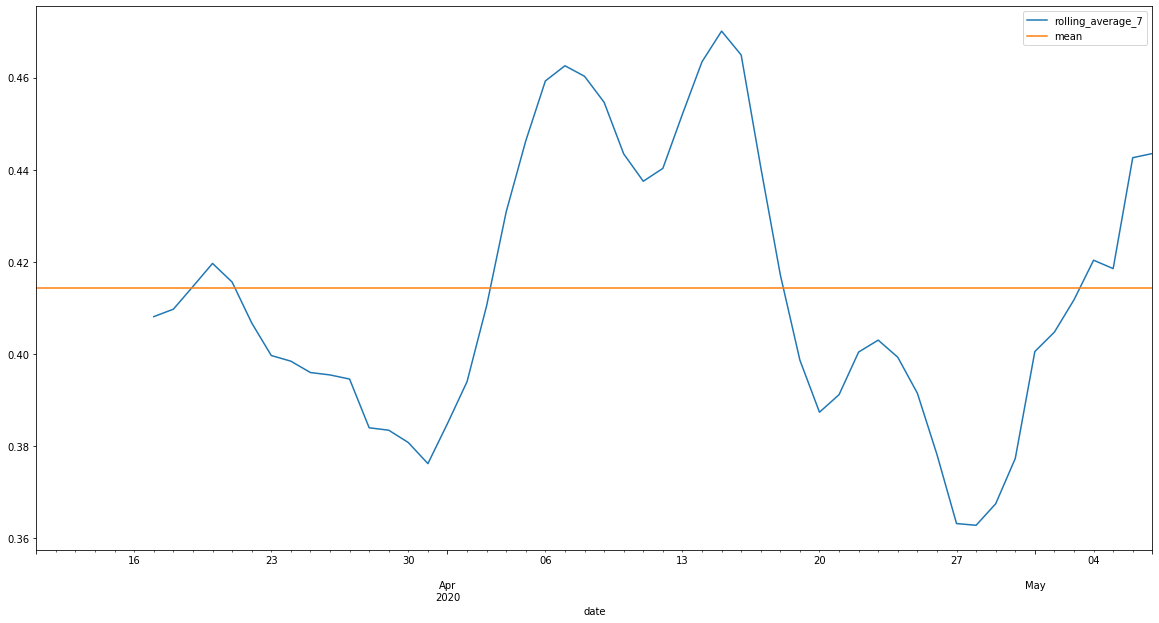

In [176]:
df_sentimental_negative_fraction['rolling_average_7'] = df_sentimental_negative_fraction['is_negative'].rolling(7, win_type ='triang').mean()
df_sentimental_negative_fraction.plot(y = ['rolling_average_7', 'mean'], figsize = (20,10))

As you can see the rolling window definitely smoothens out the data and reveals a peak in negative tweeting in the first two weeks of April which, as mentioned before, roughly corresponds to the peak of the epidemic. Our suspicion from the previous notebook is confirmed. Note though that you can see the fraction of negative tweets start to rise again at the end of April and the beginning of May. This may lead you to believe that the coincidence of the peak in negative tweeting and the peak of the epidemic could be coincidental, however this seems to be a trivial consequence of the chosen window of 7 days. I will increase the window to 14 days now and as you will see the peak in the beginnin of April will remain whilst the (start of a) peak at the end is just a regression to the mean of about 0.42

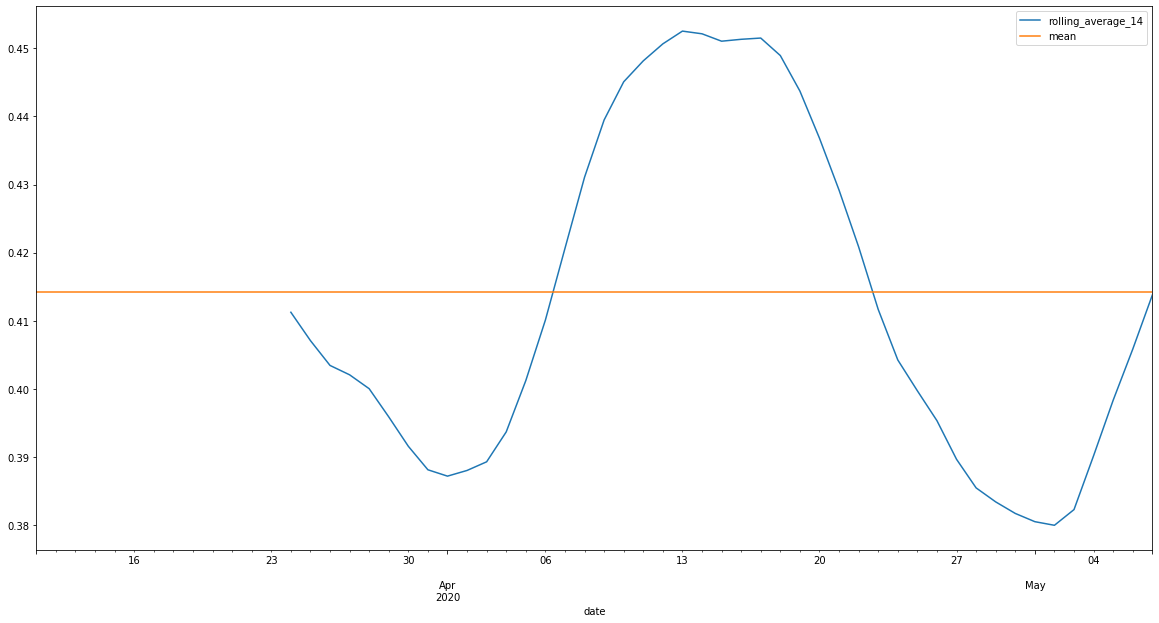

In [177]:
df_sentimental_negative_fraction['rolling_average_14']=df_sentimental_negative_fraction['is_negative'].rolling(14, win_type ='triang').mean()
df_sentimental_negative_fraction.plot(y = ['rolling_average_14', 'mean'], figsize = (20,10))

In [200]:
df_sentimental_negative_fraction.to_csv("filtered_rolling_average_negative_fraction.csv")

## Daily average sentiment of 'sentimental' tweets
For good measure we will look at one more aggregation of the sentiment per tweet data set. We will revisit the idea of the previous notebook and take a look at the daily average sentiment again. However this time we already removed one of the main causes of the noise: the neutral tweets. Moreover as we have just seen applying a rolling window smoothens out the data as it protects against outliers. We will see if these extra steps have any improvement on the resulting daily average.

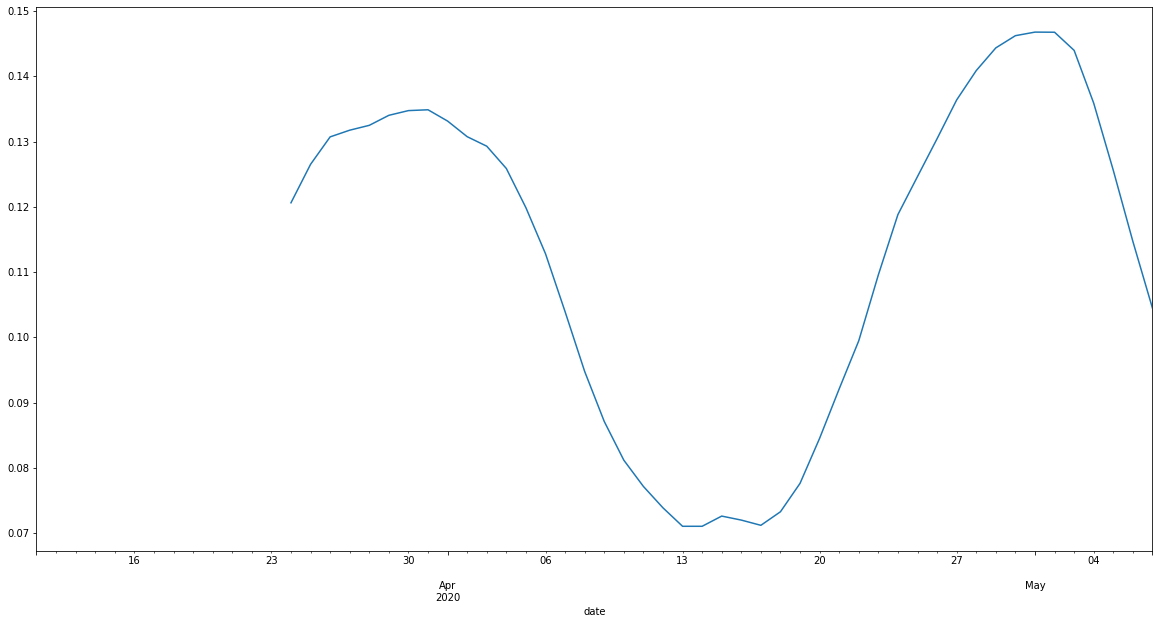

In [182]:
df_sentimental_daily_average = df_sentimental.groupby('date').agg({'sentiment': 'mean'})
df_sentimental_daily_average['rolling_average_14'] = df_sentimental_daily_average.rolling(14, win_type = 'triang').mean()
df_sentimental_daily_average['rolling_average_14'].plot(figsize = (20, 10))

In [199]:
df_sentimental_daily_average.to_csv("filtered_rolling_daily_average_sentiment.csv")

As you can see we find a similar plot as before but now inverted. In the previous notebook we finally looked at the signed quadratic deviation from the ground mean to really get a sense of the strongness of the opinion of people on a certain day compared to the expected. Analoguously we will now look at the rolling average daily quadratic deviation from the ground mean for our final visualisation:

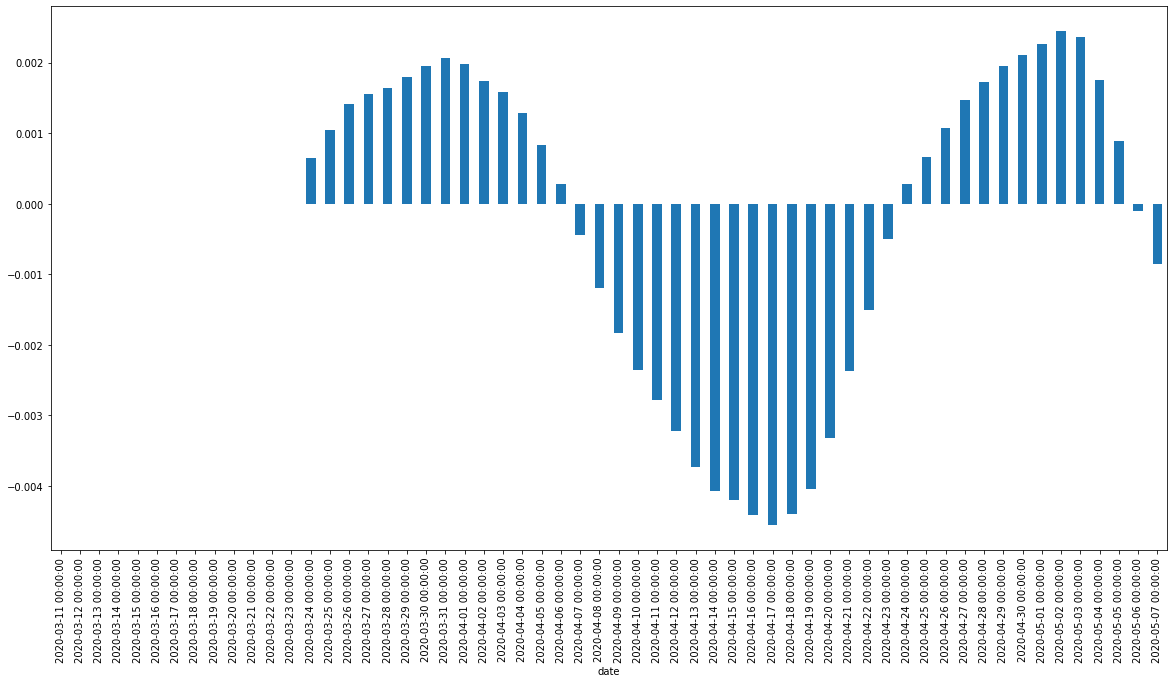

In [197]:
df_sentimental_quadratic_deviation = df_sentimental.groupby('date').agg({'sentiment': 'mean'})
df_sentimental_quadratic_deviation['mean'] = df_sentimental_quadratic_deviation['sentiment'].mean()
df_sentimental_quadratic_deviation['signed_squared_deviation'] = np.sign(df_sentimental_quadratic_deviation['sentiment'] - df_sentimental_quadratic_deviation['mean'])
df_sentimental_quadratic_deviation['signed_squared_deviation'] *= (df_sentimental_quadratic_deviation['sentiment'] - df_sentimental_quadratic_deviation['mean'])**2
df_sentimental_quadratic_deviation['rolling_14_signed_squared_deviation'] = df_sentimental_quadratic_deviation['signed_squared_deviation'].rolling(14, win_type = 'triang').mean()
df_sentimental_quadratic_deviation['rolling_14_signed_squared_deviation'].plot.bar(figsize = (20, 10))

In [198]:
df_sentimental_quadratic_deviation.to_csv("filtered_rolling_average_squared_deviation.csv")

Finally we again notice the negative peak which is now much smoother thanks to the smoothing rolling average. 

# Conclusion
After performing all previous visualisations we believe we can conclude our suspicion seems to be true. It is possible to determine the peak of the Corona virus outbreak by analysing the tweeting behaviour of people.